**Churn Analysis with Telco Customer Churn Dataset**  
Source : https://www.kaggle.com/blastchar/telco-customer-churn

# Library

In [1]:
#Basic data analysis and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns=None

# Statistics
from scipy.stats import normaltest
from scipy.stats import chi2_contingency

#Scalling
from sklearn.preprocessing import StandardScaler

#Splitting
from sklearn.model_selection import train_test_split

#Transform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

#Benchmark Model
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve,average_precision_score,plot_precision_recall_curve

#Benchmark Imbalance method
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

#Hyperparameter
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectPercentile, RFE

#SHAP
import shap

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Business Background

**Context:**  

The phenomenon of stopping customers from using a service or service from a company is called churn (customer attrition). Churn is influenced by customer statisfaction and the churn rate is inversely correlated to the level of customer statisfaction which in general if the company can maintain customer statisfaction at a high level then the churn rate will be at a low level. However, nowadays, customers have started to think critically, difficult to be satisfied, less forgiving, and easy to switch to competitors. Coupled with the rapid growth of new competitors, keeping loyal customers is a challenge in itself.

**Problem Statement**

Churn has always been a big problem for every service or service provider company because in general, churn customers are dissatisfied with the services or products provided and tend to switch to competitors. By knowing which customers will churn, the company can calculate the churn rate according to business needs and make action to prevent it.

**Goals :**  
To find how much loss caused by churn and predict which customer will churn and find out the reason so company can do action which give the company profit.

**Metric Evaluation :**

<img src='Matrix 2.png'>

**Consequencies :**

Type 1 error : False Positive  
Consequences: loss of cost, time and resource

Type 2 error : False Negative  
Consequences: Loss of customers  

Based on that consequences we want to minimize type 2 error because our goal is to prevent the loss of customers so we will focus to False Negative

# Data Understanding

In [2]:
#Load Dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Dataset Explaination**

Demographic

* gender = Male / Female
* SeniorCitizen = Senior citizen or not (>55)
* Partner = Has a partner or not
* Dependents = Has dependents or not

Services

* PhoneService	= Has a phone service or not
* MultipleLines = Has multiple lines or not
* InternetService = Kind of internet
* OnlineSecurity = Whether the customer has online security or not
* OnlineBackup = Has online backup or not
* DeviceProtection = Has device protection or not
* TechSupport = Has tech support or not
* StreamingTV	= Has streaming TV or not
* StreamingMovies = Has streaming movies or not 

Customer Information

* customerID = Customer ID
* tenure = Number of months the customer has stayed with the company / business
* Contract = The contract term of the customer 
* PaperlessBilling = Has paperless billing or not 
* PaymentMethod = The customer’s payment method
* MonthlyCharges = The amount charged to the customer monthly
* TotalCharges = The total amount charged to the customer

Target

* Churn = The measure of customers who stop using a product

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#Data type adjusment
df["TotalCharges"] = df["TotalCharges"].replace(" ","").apply(pd.to_numeric)
df["SeniorCitizen"] = np.where(df["SeniorCitizen"]==0,"No","Yes")
df["Churn"] = np.where(df["Churn"]=="No",0,1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370
std,24.559481,30.090047,2266.771362,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


In [7]:
df.describe(include = object)

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,7590-VHVEG,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,1,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


# Exploratory Dataset Analysis (EDA)

## Distribution Data Numerical

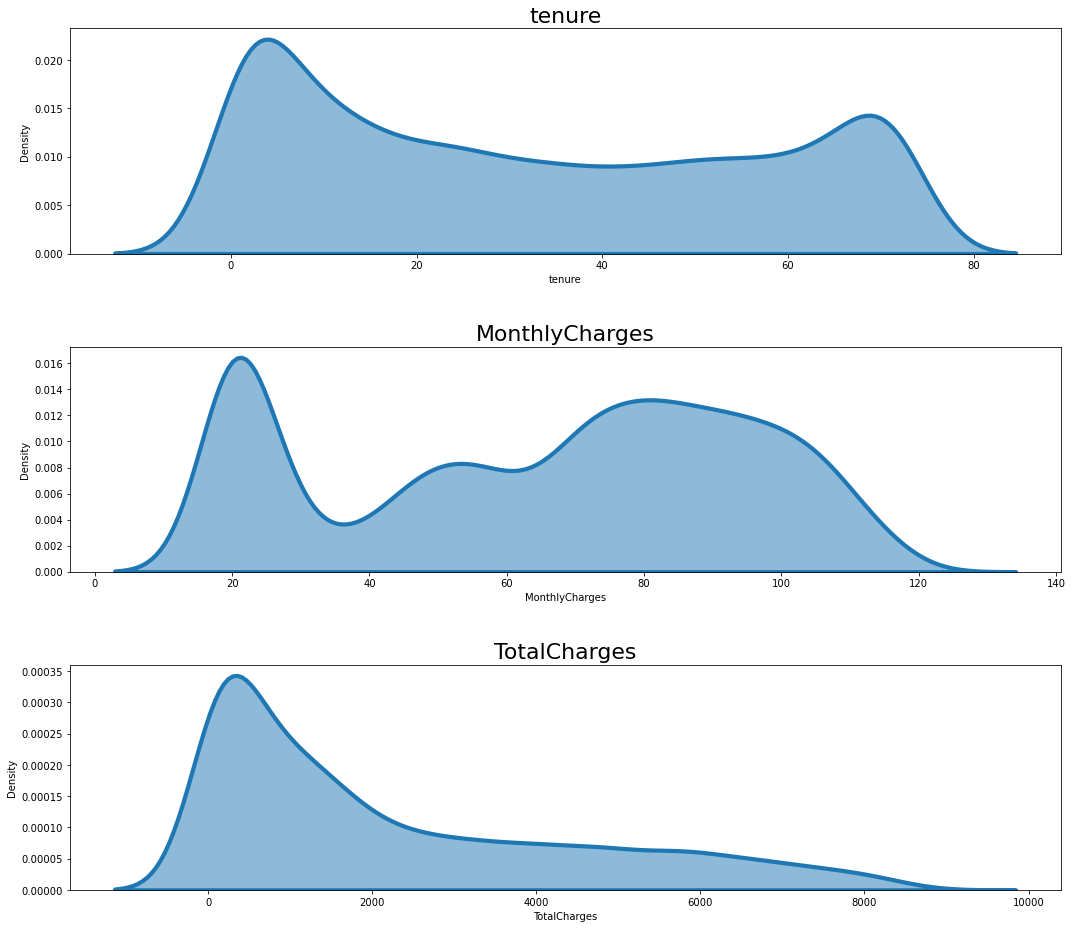

In [8]:
plt.figure(figsize=(15,13))
a = 1
numeric = list(df.drop("Churn",axis=1).describe().columns)

for i in numeric:
    plt.subplot(3,1,a)
    sns.kdeplot(df[i],shade=True, 
                 alpha=.5, linewidth=4.2)
    plt.title(i,fontsize=22)
    a+=1
    plt.tight_layout(h_pad=4)

plt.show()

In [9]:
for i in numeric:
    stats, pval = normaltest(df[i])
    if pval > 0.05:
        print(i, ': Normal distribution')
    else:
        print(i, ': Not normal distribution')

tenure : Not normal distribution
MonthlyCharges : Not normal distribution
TotalCharges : Not normal distribution


## Data Cardinalities

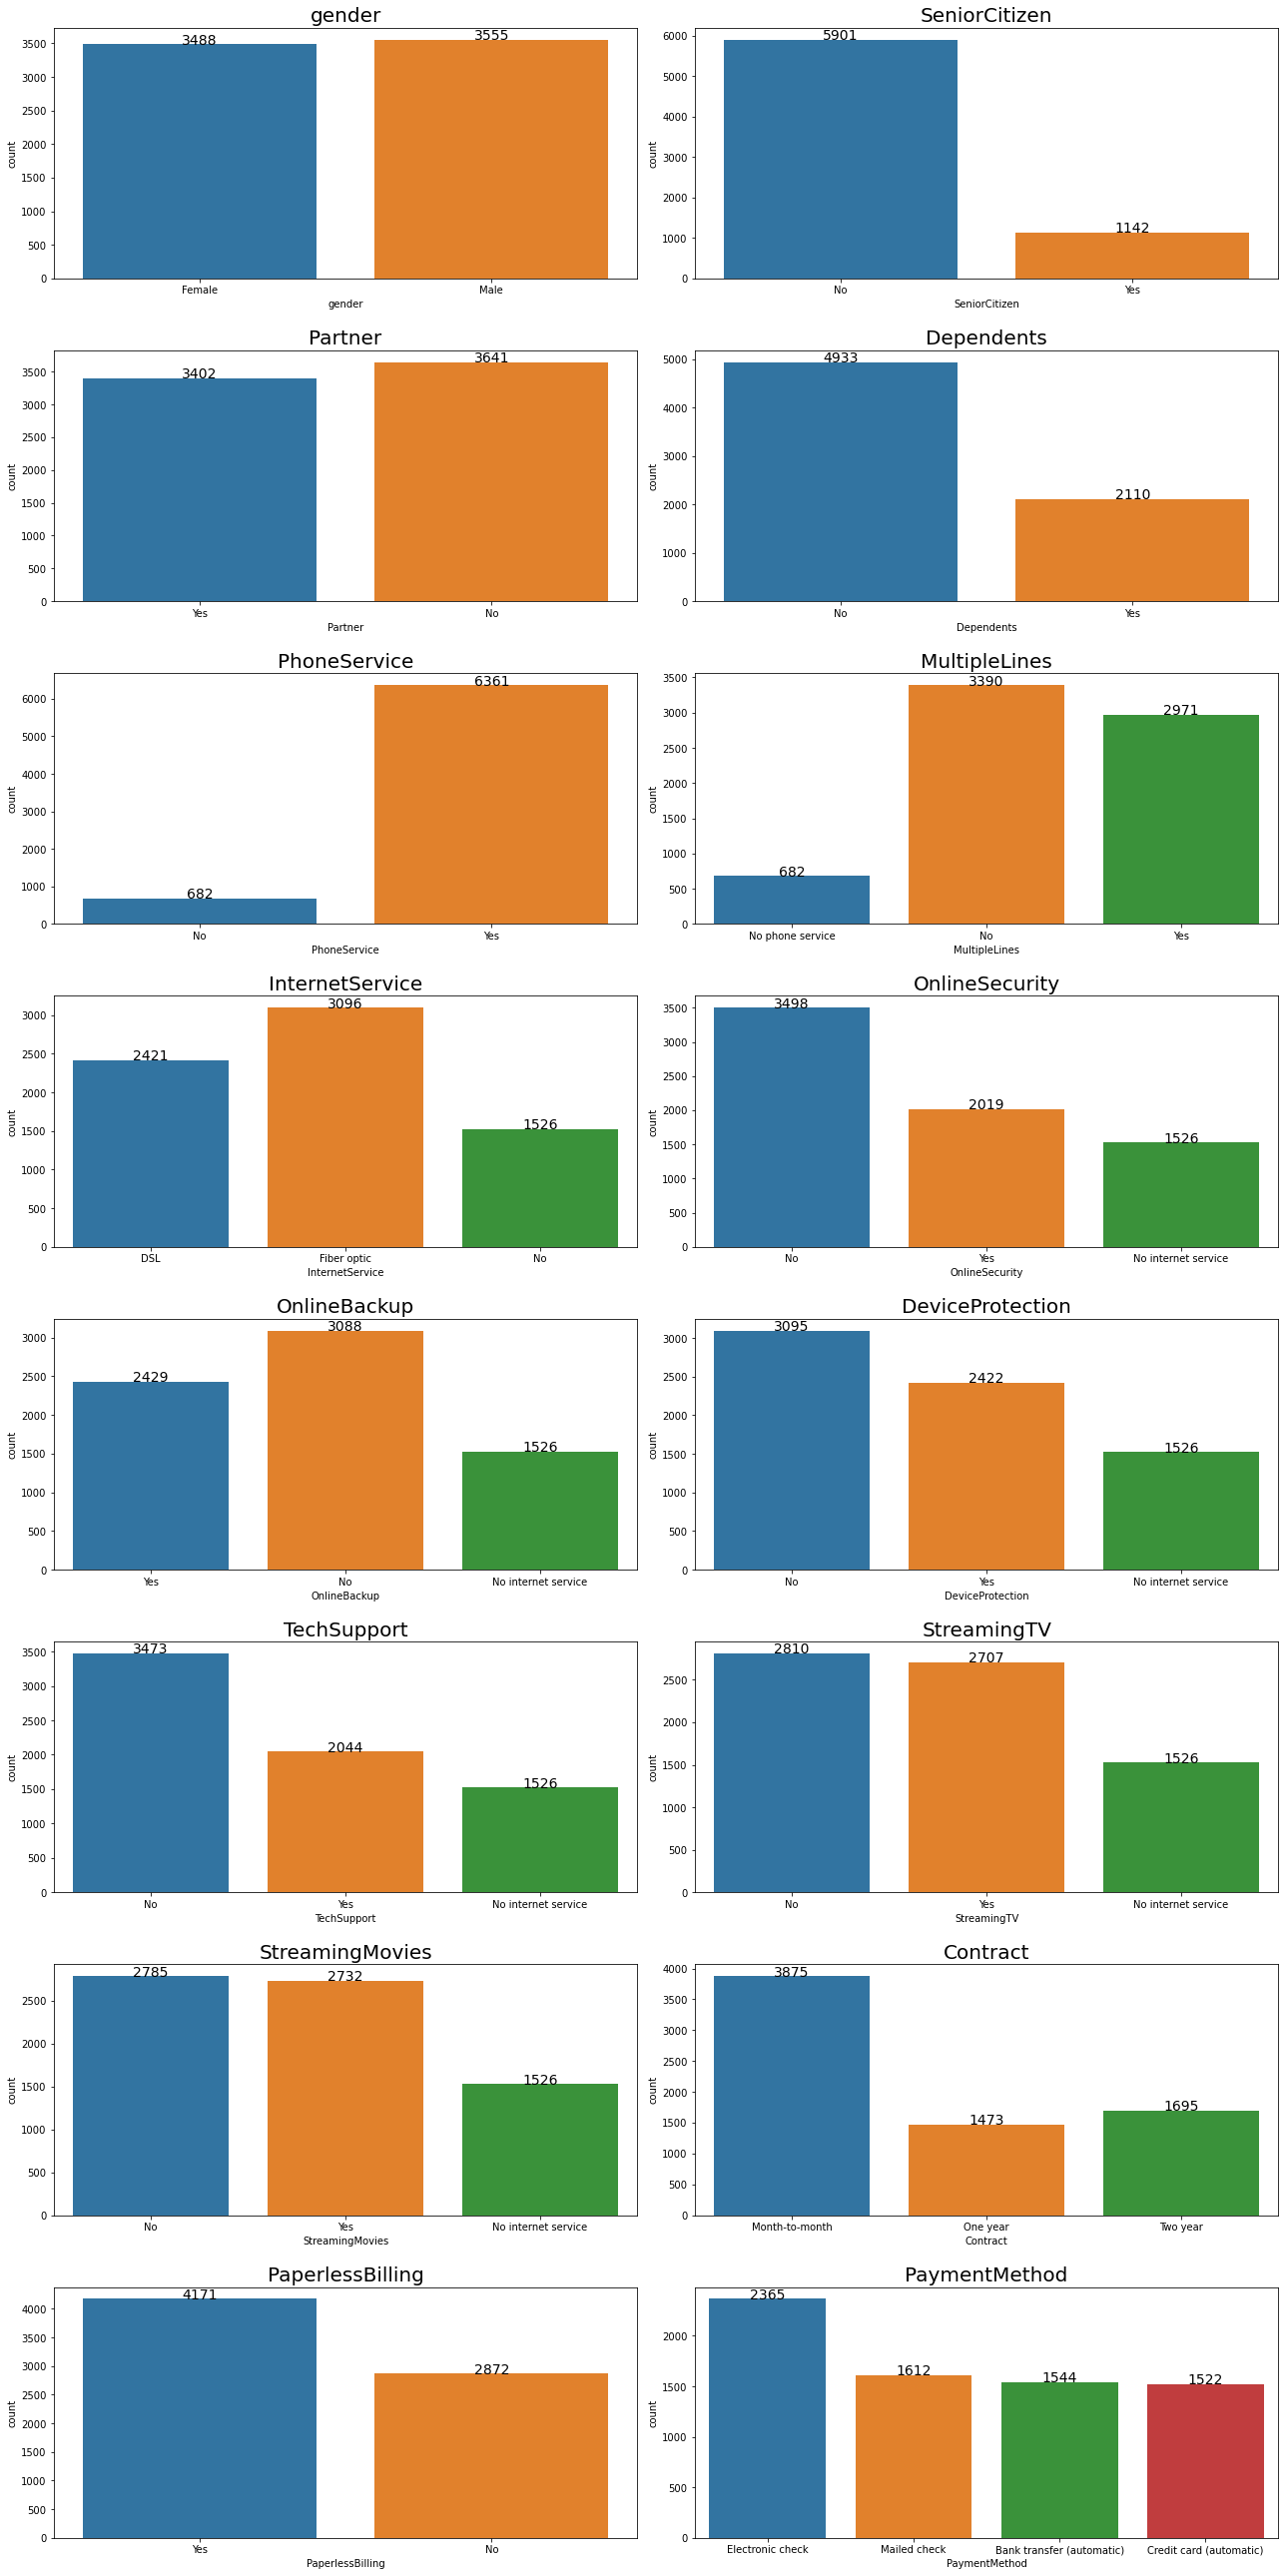

In [10]:
plt.figure(figsize=(18,40))
column_list = list((df.drop("tenure",axis=1)).columns.values)[1:17]
A = 0
for i in column_list:
    A+=1
    plt.subplot(9,2,A)
    ax = sns.countplot(data=df.fillna('NaN'), x=i)
    plt.title(i, fontsize=20)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', color='black', size=14)
plt.tight_layout(h_pad=2)

## Data Correlation

### Numerical Variable

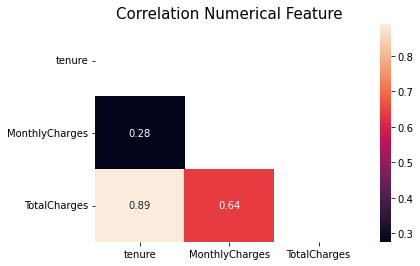

In [11]:
mask = np.triu(np.ones_like(df[numeric].corr()))
sns.heatmap(df.drop(["customerID","Churn"],axis=1).corr("spearman"),annot=True,mask=mask)
plt.title("Correlation Numerical Feature",fontsize=15)
plt.show()

* Total Charges and Tenure have strong correlation
* Total Charges and Monthly Charges have medium correlation

It can happen because Tenure and Monthly charges is calculated to make Total charges. Tenure more strong than Monthly charges because monthly charges for every people is different based on product that they consumed

### Categorical Variable

Weight of Evidence (WOE) and Information Value (IV)  
This dataset contains more data with catagorical type than numerical type. We will use nominal catagorical features for WOE and IV
    
    Information value, Predictive power
    < 0.02, useless for prediction
    0.02 - 0.1, weak predictor
    0.1 - 0.3, medium predictor
    0.3 - 0.5, strong predictor
    > 0.5, suspicious or too good

In [12]:
category = list(df.drop(["customerID","Churn"],axis=1).describe(include=object).columns)
for i in category:
    df_woe_iv = (pd.crosstab(df[i],df['Churn'], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    print(df_woe_iv,'\n------------------------------------------------------------')

Churn          0         1       woe       iv
gender                                       
Female  0.492656  0.502408  0.019602  0.00038
Male    0.507344  0.497592 -0.019409  0.00038 
------------------------------------------------------------
Churn                 0         1       woe        iv
SeniorCitizen                                        
No             0.871279  0.745318 -0.156151  0.105621
Yes            0.128721  0.254682  0.682371  0.105621 
------------------------------------------------------------
Churn           0         1       woe        iv
Partner                                        
No       0.471782  0.642055  0.308156  0.118729
Yes      0.528218  0.357945 -0.389129  0.118729 
------------------------------------------------------------
Churn              0         1       woe        iv
Dependents                                        
No          0.655199  0.825575  0.231141  0.155488
Yes         0.344801  0.174425 -0.681473  0.155488 
-----------------

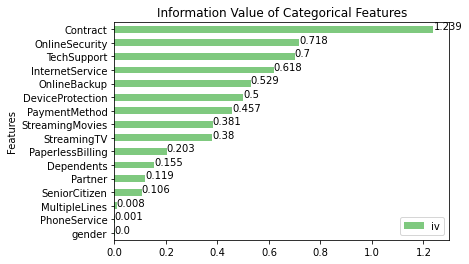

In [13]:
iv = []
for i in category:
    df_woe_iv = (pd.crosstab(df[i],df['Churn'], normalize='columns')
                 .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
                 .assign(iv=lambda dfx: np.sum(dfx['woe']*(dfx[1]-dfx[0]))))
    iv.append(df_woe_iv['iv'][0])

df_iv = pd.DataFrame({'Features':category,'iv':iv}).set_index('Features').sort_values(by='iv')
df_iv.plot(kind='barh', title='Information Value of Categorical Features',colormap = "Accent")
for index, value in enumerate(list(round(df_iv["iv"],3))):
    plt.text((value), index,
             str(value))
plt.legend(loc="lower right")
plt.show()

## Missing Values

In [14]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,0


There is 11 NaN values because tenure is 0. We will delete TotalCharges = Nan and tenure = 0 because costumers dont have experience which make they want to churn (all data is not churn) and the proportion is small.

## Data Imbalance

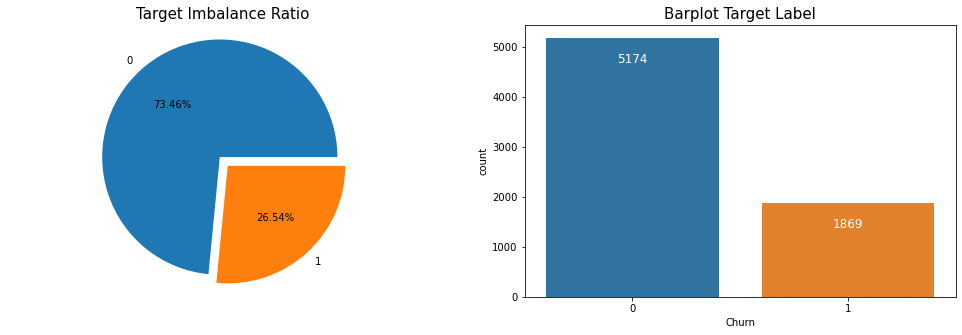

In [15]:
plt.figure(figsize=(17,(100)/20))

plt.subplot(121)
plt.pie(round(df['Churn'].value_counts()/len(df)*100,2),labels=list(df['Churn'].value_counts().index),autopct = "%.2f%%",explode = (0,0.1))
plt.axis("equal")
plt.title("Target Imbalance Ratio",size=15)

plt.subplot(122)
ax = sns.countplot(data=df, x='Churn')
plt.title("Barplot Target Label", fontsize=15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

Proportion of target is imbalance

**Metric selection:**  
<img src='imbalance.png'>

Because of target data is imbalance and we want to focus on class 1 and minimize type 2 error so we choose f2 score

## Identify Outliers

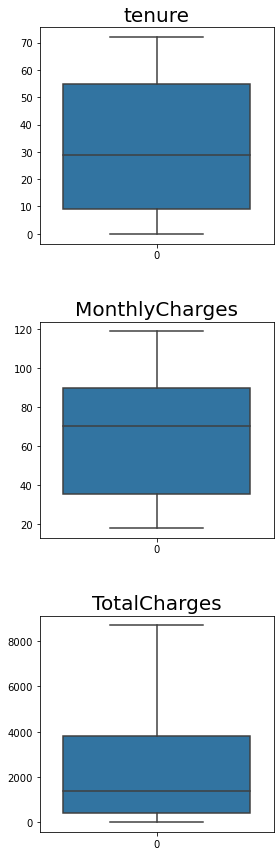

In [16]:
plt.figure(figsize=(4,12))
a = 1
numeric = list(df.drop("Churn",axis=1).describe().columns)

for i in numeric:
    plt.subplot(3,1,a)
    sns.boxplot(data = df[i])
    plt.title(i,fontsize=20)
    a+=1
    plt.tight_layout(h_pad=4)

plt.show()

There is no outlier on Tenure, Monthly Charges, and Total Charges

## Identify Duplicates

In [17]:
print("There is/are",df['customerID'].duplicated().sum(),"duplicate/s data")

There is/are 0 duplicate/s data


# Data Analytics

Visualization using Tableau<br>
Source: https://public.tableau.com/app/profile/juan1691/viz/ChurnAnalysis_16509874494110/ChurnAnalysis

## Visualization with Tableau

### Dashboard 1: Product Services Analysis

<img src='Dashboard1.png'>

* Total Customers = 7043
* User Phone Service = 6361 
    * Number of customer who using Phone Service only = 1526
* User Internet = 5517 
    * The most using line is Fiber optic
* User Streaming Movies = 2732
    * Number of customer who has internet and not using Streaming movies = 2785
* User Streaming TV = 2707
    * Number of customer who has internet and not using Streaming movies = 2810

### Dashboard 2: Customer Transaction

<img src='Dashboard2.png'>

* Payment Method
    * Electronic Check is the most favorite way to pay the bill.
    * Electronic Check is also have the most customers churn.
* Contract
    * Month to month is the most favorite contract period followed with Two years.
    * Month to month is also have the most customers churn.
* Billing
    * Customer like to have paperless billing but some customers still need paper billing.
    * Paperless billing have more customer who churn than customer who use paper billing.

### Dashboard 3: Customer Information

<img src='Dashboard3.png'>

* Gender: Proportion of gender is same.
* Partner: Proportion of partner is same.
* Senior Citizen: Proportion of Non senior citizen is higher than senior citizen.
* Dependent: Proportion of customer who have dependent  is higher than who dont have.
* Support
    * Number of customer who using tech support = 2044
    * Customer who dont use tech support more churn than who use it.

### Dashboard 4: Personal Information

<img src='Dashboard4.png'>

* Gender
    * Proportion between male and female who chrun is same for number of customers, average tenure, average monthly charges, and average Total charges
* Senior Citizen
    * Non senior citizen is have number of churn than senior citizen with average tenure is 16.94
    * Senior citizen who churn have long tenure, have higher average monthly charges and total charges than non senior citizen who churn
* Partner
    * Number of customer who dont have partner is higher than customer who have.
* Dependent 
    * Number of customer who dont have dependent is higher than customer who have.
* Overall 
    * Tenure customer who churn is less than customer who not churn.
    * Customer who have month to month contract base have the most the number of churn than the others.

### Dashboard 5: Personal Information

<img src='Dashboard5.png'>

* Internet Service Detail
    * Fiber optic with no online security and no online backup is the most choosen by customer.
    * Fiber optic with no onine security have the customers who churn.
* Phone Service Detail
    * Phone service with multiple line is the most choosen by customer.
    * Customer who use phone service have more customer churn than customer who not using it.
* Protection
    * Customer who have internet service and not using device protection = 3095
    * Customer who have internet service and not using device protection have the most number of churn.

## Loss caused by Churn

In [18]:
print("There are", df[df["Churn"]==1]["Churn"].count(), "customers churn")

There are 1869 customers churn


In [19]:
loss = df.groupby(["Churn"]).sum()["MonthlyCharges"]
print(loss)

Churn
0    316985.75
1    139130.85
Name: MonthlyCharges, dtype: float64


In [20]:
print("Company will loss","${:,.2f}".format(round(loss[1])), "/month or","{:,}%".format(round(loss[1]/(df["MonthlyCharges"].sum())*100)), "from total")

Company will loss $139,131.00 /month or 31.0% from total


In [21]:
print("Charges per customer / month: ","${:,.2f}".format(round(loss[1])/df[df["Churn"]==1]["Churn"].count()))

Charges per customer / month:  $74.44


In [22]:
print("Average tenure: ","{:,.2f}".format(df["tenure"].mean()))

Average tenure:  32.37


## Data Proportion based on Target

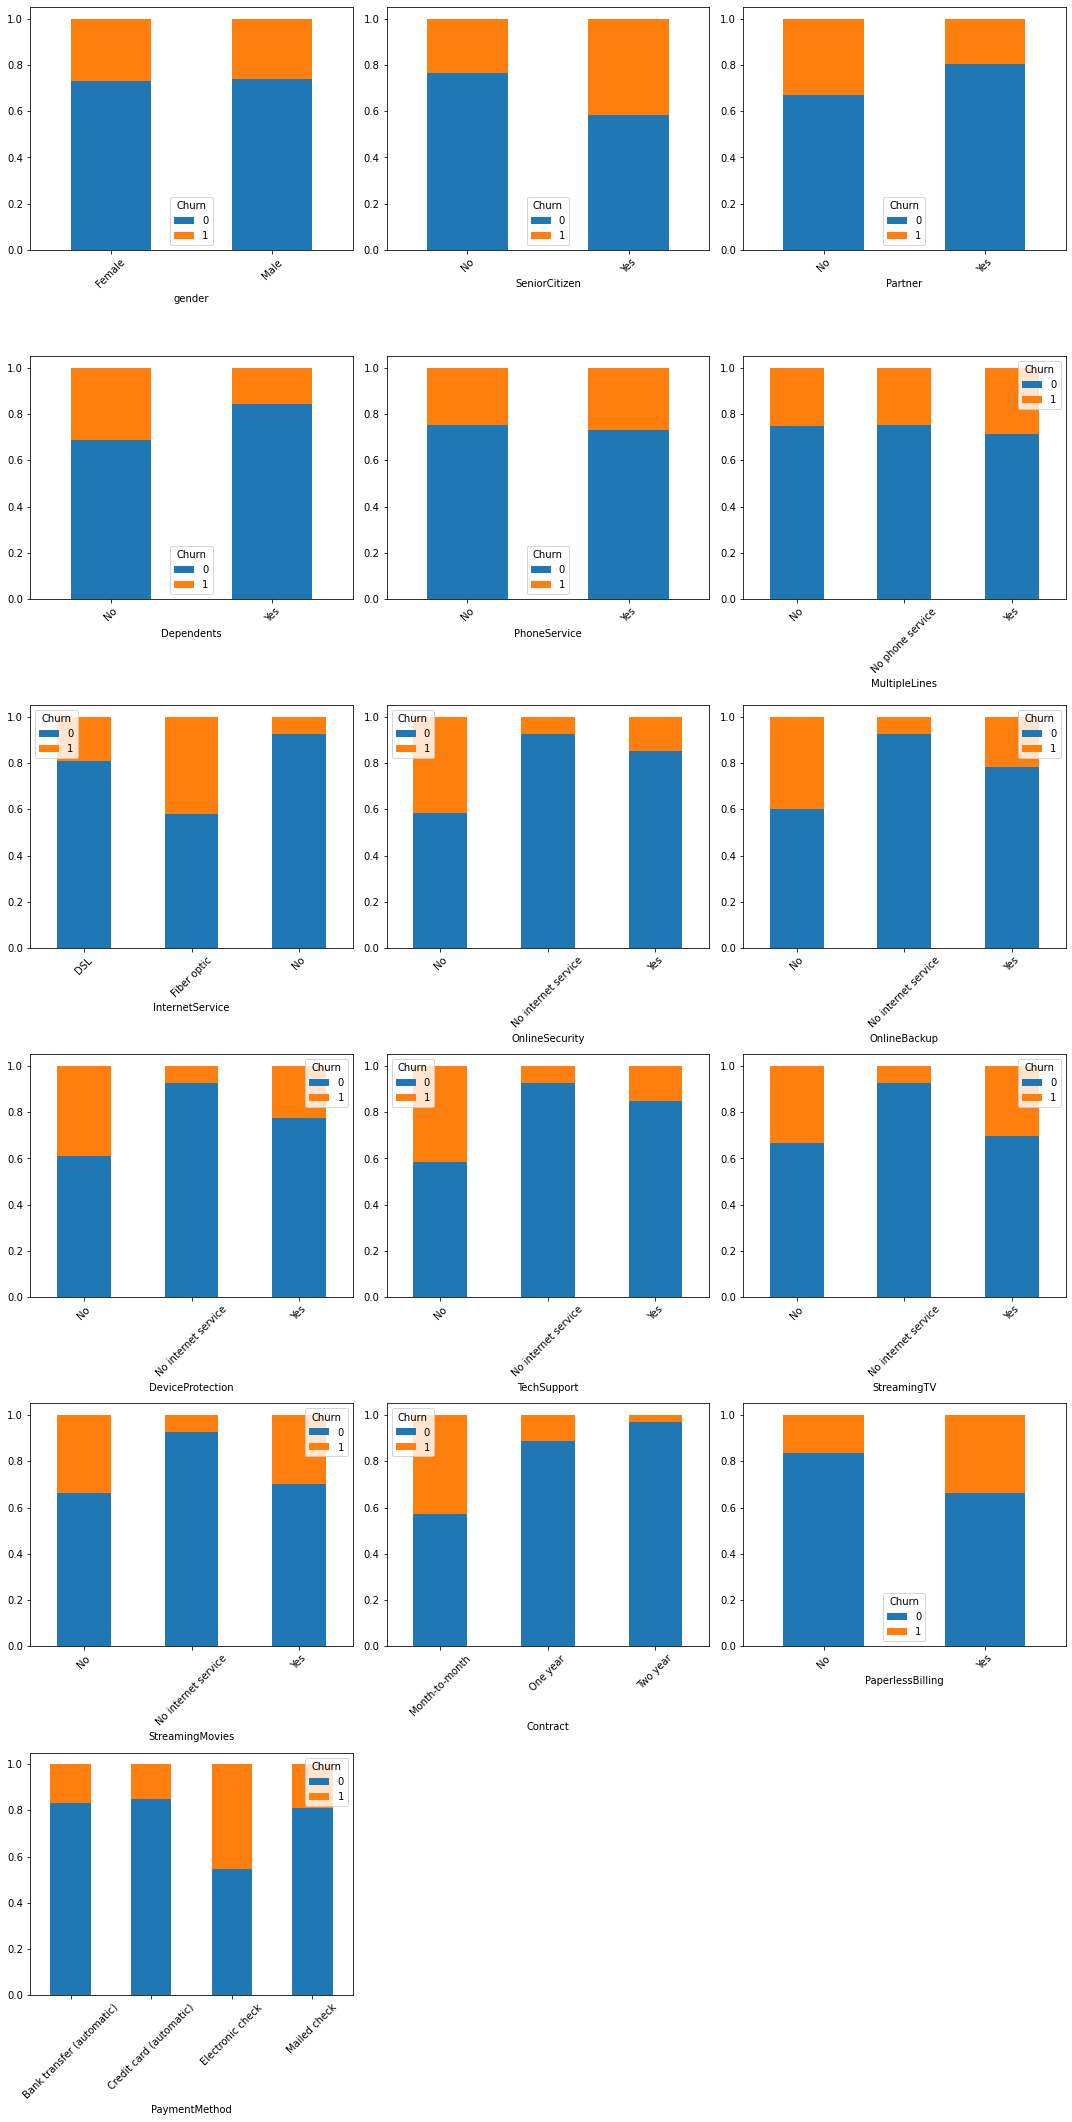

In [23]:
count = 0
fig = plt.figure(figsize=(15,30))

for i in column_list:
      count +=1
      ax= plt.subplot(6,3,count)
      pd.crosstab(df[i],df['Churn'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
      fig.tight_layout()
      plt.xticks(rotation=45)

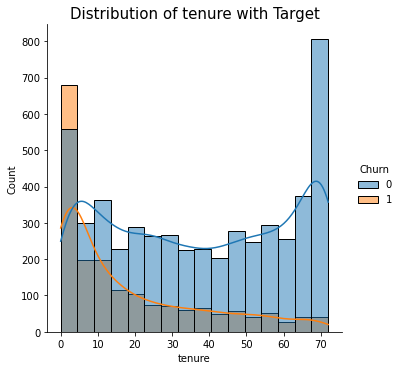

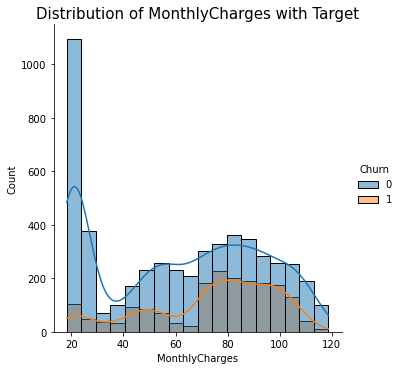

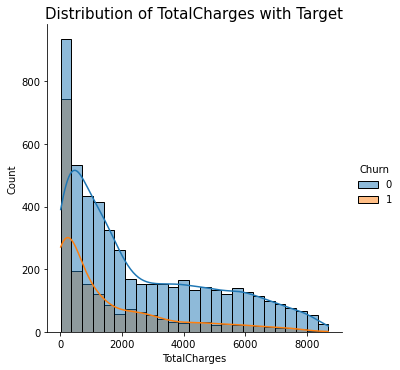

In [24]:
for i in numeric:
    sns.displot(x=i,
                hue='Churn',
                data=df,
                stat="count",
                kde=True)
    plt.title(f"Distribution of {i} with Target",fontsize=15)

## Independent Test with Chi-squared

### Independent Test between Churn and Features

Hypothesis
* Ho : There is no relation between feature and target
* Ha : There is a relation between feature and target

In [25]:
for i in column_list:
    chisqt = pd.crosstab(df["Churn"], df[i], margins=True)
    value = np.array([chisqt.iloc[0],
                      chisqt.iloc[1]])
    stat,pval,dof,exp = chi2_contingency(value)
    alpha = 0.05
    if pval <= alpha:
        print(i, ": Dependent (reject H0)")
    else:
        print(i, ": Independent (H0 holds true)")

gender : Independent (H0 holds true)
SeniorCitizen : Dependent (reject H0)
Partner : Dependent (reject H0)
Dependents : Dependent (reject H0)
PhoneService : Independent (H0 holds true)
MultipleLines : Dependent (reject H0)
InternetService : Dependent (reject H0)
OnlineSecurity : Dependent (reject H0)
OnlineBackup : Dependent (reject H0)
DeviceProtection : Dependent (reject H0)
TechSupport : Dependent (reject H0)
StreamingTV : Dependent (reject H0)
StreamingMovies : Dependent (reject H0)
Contract : Dependent (reject H0)
PaperlessBilling : Dependent (reject H0)
PaymentMethod : Dependent (reject H0)


### Independent Test between Senior Citizen and Features

Hypothesis
* Ho : There is no relation between feature and Senior Citizen
* Ha : There is a relation between feature and Senior Citizen

In [26]:
for i in column_list:
    chisqt = pd.crosstab(df["SeniorCitizen"], df[i], margins=True)
    value = np.array([chisqt.iloc[0],
                      chisqt.iloc[1]])
    stat,pval,dof,exp = chi2_contingency(value)
    alpha = 0.05
    if pval <= alpha:
        print(i, ": Dependent (reject H0)")
    else:
        print(i, ": Independent (H0 holds true)")

gender : Independent (H0 holds true)
SeniorCitizen : Dependent (reject H0)
Partner : Independent (H0 holds true)
Dependents : Dependent (reject H0)
PhoneService : Independent (H0 holds true)
MultipleLines : Dependent (reject H0)
InternetService : Dependent (reject H0)
OnlineSecurity : Dependent (reject H0)
OnlineBackup : Dependent (reject H0)
DeviceProtection : Dependent (reject H0)
TechSupport : Dependent (reject H0)
StreamingTV : Dependent (reject H0)
StreamingMovies : Dependent (reject H0)
Contract : Dependent (reject H0)
PaperlessBilling : Dependent (reject H0)
PaymentMethod : Dependent (reject H0)


## Senior Citizen Feature

In [27]:
sc = df[(df["SeniorCitizen"]=="Yes")]
sc.groupby(["Dependents","PaperlessBilling"]).count()["Churn"]

Dependents  PaperlessBilling
No          No                  250
            Yes                 801
Yes         No                   16
            Yes                  75
Name: Churn, dtype: int64

* Customer who Senior Citizen with Dependents have less probability to churn
* Customer who Senior Citizen with PaperlessBilling have more probability to churn

# Preprocessing

## Missing Values

In [28]:
df.drop(df[df["tenure"]==0].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


## Transformer

We drop CustomerID because it is unique data for every customer and dont have other information

In [29]:
df.drop(["customerID"],axis=1,inplace=True)

In [30]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), column_list)
], remainder='passthrough')

transformer_scaling = ColumnTransformer([
    ('onehot', OneHotEncoder(), column_list),
    ("standart",StandardScaler(),numeric)
], remainder='passthrough')

## Splitting Data

In [31]:
x = df.drop(columns=["Churn"])
y = df["Churn"]
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=.2,random_state=2020)

#  Model Selection

## Benchmarking Model with Data Train

We will try several models:
* Logistic Regression
* KNN 
* Decision Tree
* Random Forest
* XGBoost
* Catboost

In [32]:
tree=DecisionTreeClassifier(max_depth = 3, random_state=2020)
logreg=LogisticRegression(max_iter = 1000, random_state=2020)
rf=RandomForestClassifier(random_state=2020)
knn = knn=KNeighborsClassifier()
xgb = XGBClassifier()
catboost= CatBoostClassifier(n_estimators=100,
                                   cat_features = column_list,verbose=False)

In [33]:
model=[knn,tree,logreg,rf,xgb,"catboost"]
beta_score=[]
mean=[]
std=[]
fbeta_scorer = make_scorer(fbeta_score, beta=2)

for i in model:
    skfold=StratifiedKFold(n_splits=5)
    if i == knn:
        estimator =Pipeline([
            ("preprocess",transformer_scaling),
            ("model",i)])
    elif i == "catboost":
        estimator = catboost
    else:
        estimator=Pipeline([
            ("preprocess",transformer),
            ("model",i)])
        
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring=fbeta_scorer)
    beta_score.append(model_cv)
    mean.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({
    "model":["KNN","Decision Tree","Logistic Regression","Random Forest","XGBoost","Catboost"],
    "Mean F2 Score":mean,
    "Std":std
}).set_index('model').sort_values(by='Mean F2 Score',ascending=False)

[09:34:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:34:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:34:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:34:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,Mean F2 Score,Std
model,,
Logistic Regression,0.558147,0.022469
Catboost,0.546704,0.031505
XGBoost,0.535740,0.027821
KNN,0.532619,0.011233
Random Forest,0.507750,0.029588
Decision Tree,0.421327,0.034664


## Model Benchmarking: Data test

In [34]:
f2_score= []
cr_bm = []
a=0

for i in model:
    skfold=StratifiedKFold(n_splits=5)
    if i == knn:
        estimator =Pipeline([
            ("preprocess",transformer_scaling),
            ("model",i)])
    elif i == "catboost":
        estimator = catboost
    else:
        estimator=Pipeline([
            ("preprocess",transformer),
            ("model",i)])    
    estimator.fit(x_train,y_train)
    y_pred_bm = estimator.predict(x_test)
    f2_score.append(fbeta_score(y_test,y_pred_bm,beta=2))
    cr_bm.append(classification_report(y_test,y_pred_bm))
    print(i,'\n', cr_bm[a])
    a+=1

pd.DataFrame({
    "model":["KNN","Decision Tree","Logistic Regression","Random Forest","XGBoost","Catboost"],
    "F2 Score Data Test":f2_score,
    "Std":std
}).set_index('model').sort_values(by='F2 Score Data Test',ascending=False)

KNeighborsClassifier() 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84      1033
           1       0.55      0.52      0.53       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.69      1407
weighted avg       0.76      0.76      0.76      1407

DecisionTreeClassifier(max_depth=3, random_state=2020) 
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      1033
           1       0.68      0.38      0.49       374

    accuracy                           0.79      1407
   macro avg       0.75      0.66      0.68      1407
weighted avg       0.77      0.79      0.77      1407

LogisticRegression(max_iter=1000, random_state=2020) 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1033
           1       0.68      0.56      0.62       374

    accuracy                           0.81  

,F2 Score Data Test,Std
model,,
Logistic Regression,0.582040,0.022469
XGBoost,0.530556,0.027821
KNN,0.523319,0.011233
Catboost,0.514997,0.031505
Random Forest,0.500562,0.029588
Decision Tree,0.414219,0.034664


## Comparison Models in Data Train & Data Test

In [35]:
pd.DataFrame({
    "model":["KNN","Decision Tree","Logistic Regression","Random Forest","XGBoost","Catboost"],
    "F2 Score Data Train":mean,
    "F2 Score Data Test":f2_score
}).set_index('model').sort_values(by='F2 Score Data Test',ascending=False)

,F2 Score Data Train,F2 Score Data Test
model,,
Logistic Regression,0.558147,0.582040
XGBoost,0.535740,0.530556
KNN,0.532619,0.523319
Catboost,0.546704,0.514997
Random Forest,0.507750,0.500562
Decision Tree,0.421327,0.414219


In [36]:
print("Logistic Regression \n" ,cr_bm[2])

Logistic Regression 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1033
           1       0.68      0.56      0.62       374

    accuracy                           0.81      1407
   macro avg       0.77      0.73      0.75      1407
weighted avg       0.81      0.81      0.81      1407



Logistic Regression get best performance with recall 58%

## Feature Selection

### Feature Selection based on IV and Chi2

In [37]:
x_sel = df.drop(columns=["Churn","gender","PhoneService"])
y_sel = df["Churn"]
x_train_sel,x_test_sel,y_train_sel,y_test_sel=train_test_split(x_sel,y_sel,stratify=y_sel,test_size=.2,random_state=2020)

In [38]:
column_list_sel = list((df.drop(columns=["Churn","gender","PhoneService"])))
transformer_sel = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'), column_list_sel)
], remainder='passthrough')

In [39]:
skfold=StratifiedKFold(n_splits=5)
estimator_sel =Pipeline([
            ("preprocess",transformer_sel),
            ("model",logreg)])
estimator_sel.fit(x_train_sel,y_train_sel)
y_pred_sel = estimator_sel.predict(x_test_sel)
f2_score_sel = fbeta_score(y_test_sel,y_pred_sel,beta=2)
cr_sel = classification_report(y_test_sel,y_pred_sel)
print("Logistic Regression: ",f2_score_sel,'\n', cr_sel)

Logistic Regression:  0.5295429208472686 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



### Comparison Feature Selection with All Feature

In [40]:
pd.DataFrame({
    "Feature":["Default","Selection"],
    "F2 Score":[mean[2],f2_score_sel]
}).set_index('Feature').sort_values(by='F2 Score',ascending=False)

,F2 Score
Feature,
Default,0.558147
Selection,0.529543


In [41]:
print("Default \n",cr_bm[2],"\n Selection \n", cr_sel)

Default 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1033
           1       0.68      0.56      0.62       374

    accuracy                           0.81      1407
   macro avg       0.77      0.73      0.75      1407
weighted avg       0.81      0.81      0.81      1407
 
 Selection 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



We will use All feature to predict the target

# Imbalance Method

We will try several methods:
* Nearmiss
* SMOTE
* Class Weight

In [42]:
nm=NearMiss()
smote=SMOTE(random_state=2020)
logreg_cw=LogisticRegression(max_iter = 1000, random_state=2020,class_weight="balanced")

## Method Benchmarking

In [43]:
imb = [nm,smote,logreg_cw]
beta_score_imb=[]
mean_imb=[]
std_imb=[]

for i in imb:
    skfold=StratifiedKFold(n_splits=5)
    if i == logreg_cw:
        estimator =Pipeline([
            ("preprocess",transformer),
            ("model",i)])
    else:
        estimator=Pipeline([
            ("preprocess",transformer),
            ("resampling",i),
            ("model",logreg)])
        
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring=fbeta_scorer)
    beta_score_imb.append(model_cv)
    mean_imb.append(model_cv.mean())
    std_imb.append(model_cv.std())
    
pd.DataFrame({
    "Resampling":["Nearmiss","SMOTE","Class Weighted"],
    "Mean F2 Score IMB":mean_imb,
    "Std IMB":std_imb
}).set_index('Resampling').sort_values(by='Mean F2 Score IMB',ascending=False)

,Mean F2 Score IMB,Std IMB
Resampling,,
Class Weighted,0.717082,0.027903
SMOTE,0.712821,0.028503
Nearmiss,0.658361,0.009498


## Imbalance Handling in Data Test

In [44]:
f2_score_imb= []
cr_imb = []
a=0

for i in imb:
    skfold=StratifiedKFold(n_splits=5)
    if i == logreg_cw:
        estimator =Pipeline([
            ("preprocess",transformer),
            ("model",i)])
    else:
        estimator=Pipeline([
            ("preprocess",transformer),
            ("resampling",i),
            ("model",logreg)])
    estimator.fit(x_train,y_train)
    y_pred_bm = estimator.predict(x_test)
    f2_score_imb.append(fbeta_score(y_test,y_pred_bm,beta=2))
    cr_imb.append(classification_report(y_test,y_pred_bm))
    print(i,'\n', cr_imb[a])
    a+=1

pd.DataFrame({
    "Resampling":["Nearmiss","SMOTE","Class Weighted"],
    "Mean F2 Score IMB Test":f2_score_imb,
}).set_index('Resampling').sort_values(by='Mean F2 Score IMB Test',ascending=False)

NearMiss() 
               precision    recall  f1-score   support

           0       0.88      0.71      0.79      1033
           1       0.48      0.74      0.58       374

    accuracy                           0.72      1407
   macro avg       0.68      0.73      0.69      1407
weighted avg       0.78      0.72      0.74      1407

SMOTE(random_state=2020) 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.64       374

    accuracy                           0.76      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.76      0.77      1407

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2020) 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.64       374

    accuracy                           0.75      1407
   macro

,Mean F2 Score IMB Test
Resampling,
SMOTE,0.728155
Class Weighted,0.727405
Nearmiss,0.667634


## Comparison Imbalance Methods in Data Train & Data Test

In [45]:
pd.DataFrame({
    "Method":["NearMiss","SMOTE","Class Weight"],
    "Data Train":mean_imb,
    "Data Test":f2_score_imb
}).set_index('Method').sort_values(by='Data Test',ascending=False)

,Data Train,Data Test
Method,,
SMOTE,0.712821,0.728155
Class Weight,0.717082,0.727405
NearMiss,0.658361,0.667634


In [46]:
print("Logistic Regression with Class Weighted \n",cr_imb[2])

Logistic Regression with Class Weighted 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.64       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.75      0.77      1407



We will use Class Weighted because SMOTE has bigger standard deviation which mean it more unstable and the performance between SMOTE and Class Weighted have small difference

# Model Tuning

## Hyperparameter Tuning

In [47]:
estimator=Pipeline([
            ("preprocess",transformer),
            ("model",logreg_cw)])

In [48]:
estimator.get_params()

{'memory': None,
 'steps': [('preprocess',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot', OneHotEncoder(),
                                    ['gender', 'SeniorCitizen', 'Partner',
                                     'Dependents', 'PhoneService', 'MultipleLines',
                                     'InternetService', 'OnlineSecurity',
                                     'OnlineBackup', 'DeviceProtection',
                                     'TechSupport', 'StreamingTV',
                                     'StreamingMovies', 'Contract',
                                     'PaperlessBilling', 'PaymentMethod'])])),
  ('model',
   LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2020))],
 'verbose': False,
 'preprocess': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehot', OneHotEncoder(),
                                  ['gender', 'SeniorCitizen', 'Partner',
                     

In [49]:
hyperparam_space={
    "model__solver":["lbfgs","liblinear","sag","saga"],
    "model__C": [100,10,1,0.1,0.01,0.001],
    "model__max_iter": [50,100,150]
}

In [50]:
grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    scoring=fbeta_scorer, 
    n_jobs=-1)

In [51]:
grid_search.fit(x_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                    

In [52]:
best_model=grid_search.best_estimator_
best_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot', OneHotEncoder(),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   '

In [53]:
y_pred_tuning=best_model.predict(x_test)
cr_tun=classification_report(y_test,y_pred_tuning)
f2_tun = fbeta_score(y_test,y_pred_tuning,beta=2)
print("Logistic Regression with Class Weight and After Tuning: ",f2_tun)
print("\n",cr_tun)

Logistic Regression with Class Weight and After Tuning:  0.7249879168680522

               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1033
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.77      1407



## Comparison between Hyperparameter Model and Before Tuning

In [54]:
pd.DataFrame({
    "Tuning":["Before Tuning","After Tuning"],
    "F2 Score":[f2_score_imb[2],f2_tun]
}).set_index('Tuning').sort_values(by='F2 Score',ascending=False)

,F2 Score
Tuning,
Before Tuning,0.727405
After Tuning,0.724988


In [55]:
print("Before Tuning \n",cr_imb[2],"\n After Tuning \n", cr_tun)

Before Tuning 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.64       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.75      0.77      1407
 
 After Tuning 
               precision    recall  f1-score   support

           0       0.91      0.74      0.81      1033
           1       0.52      0.80      0.63       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.77      1407



We will use model before Hyperparameter Tuning

# Interpretable & Explainable of ML

## SHAP

In [56]:
shap.initjs()

In [57]:
x_train_shap = x_train.copy()
x_test_shap = x_test.copy()

for i in column_list:
    le = LabelEncoder()
    le.fit(df[i])
    x_test_shap[i] = le.transform(x_test[i])
    x_train_shap[i] = le.transform(x_train[i])
    
for i in x_train_shap.select_dtypes(object).columns:
    x_train_shap[i] = pd.to_numeric(x_train_shap[i])

In [58]:
logreg_cw.fit(x_train_shap, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=2020)

In [59]:
explainer = shap.LinearExplainer(logreg_cw, x_train_shap, feature_dependence="independent")
shap_values = explainer.shap_values(x_test_shap)
feature_names = list(x_train.columns)

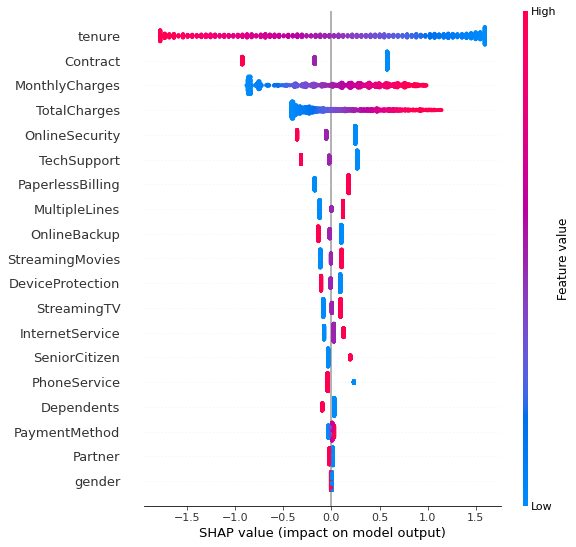

In [60]:
shap.summary_plot(shap_values, x_test_shap, feature_names=feature_names)

Payment and duration of Subscribe have the most impact to customer churn or not
* Tenure: Short period of tenure increase probability the customer to churn.
* Contract: Short period of subscribe increase probability the customer to churn.
* Monthly Charges: High montlhy charges increase probability the customer to churn.
* Total Charges : High total charges increase probability the customer to churn.
* Payment method : Customer with automatic payment have less probability to churn.

Product & Services also give impact to customer churn or not
* Online Security, Backup, Device Protection, Multiple lines and Phone Service : Customer who not use that product have more probability to churn.
* Tech Support : Customer who not use tech support have more probability to churn.
* Internet Service : Customer who not use Internet service have more probability to churn.
* Streaming Movies and TV : Customer who use streaming Movies or TV have more probability to churn.

Personal information can help us to determine customer who will churn or not
* Dependent: Customer who have dependent have less probability to churn.
* Senior citizen : Senior citizen have more probability to churn.
* Partner & Gender : Partner and Gender have less impact to make customer churn.

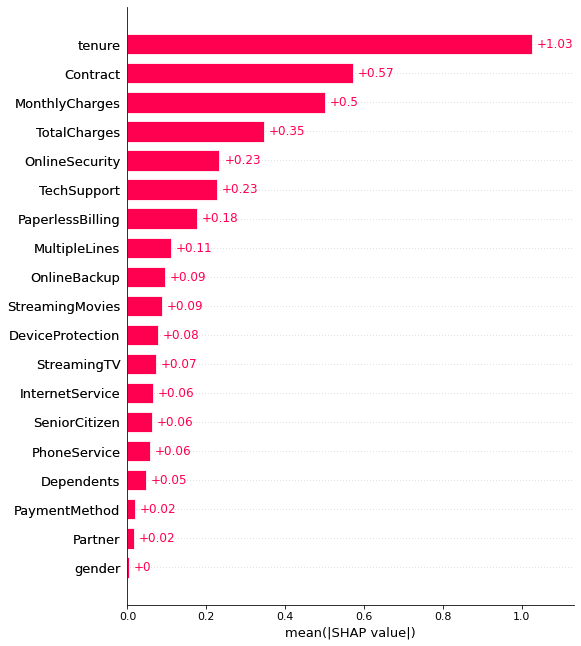

In [61]:
shap.plots.bar(explainer(x_test_shap),max_display=20)

In [62]:
def plot_shap(ind):
    chosen_instance = x_test_shap.iloc[[ind]]
    shap_values = explainer.shap_values(chosen_instance)
    shap.force_plot(explainer.expected_value, shap_values[0], chosen_instance, matplotlib=True)

y_prob = logreg_cw.predict_proba(x_test_shap)[:,1]
y_pred = logreg_cw.predict(x_test_shap)

The model predict customer will: churn from y_test


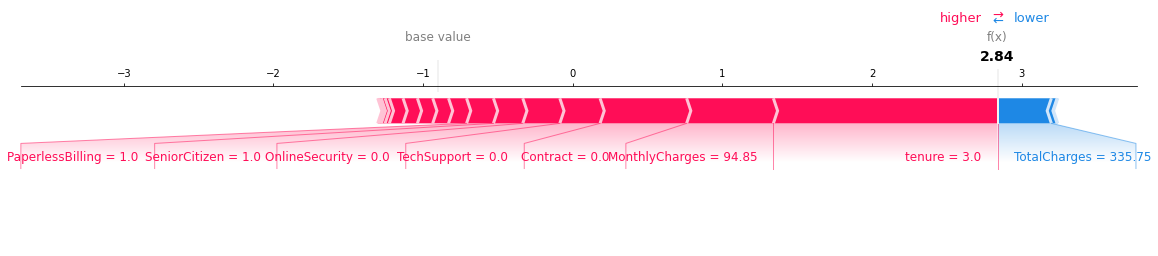

In [63]:
print(f'The model predict customer will: {("churn" if y_test[np.argmax(y_prob)]==1 else "not churn")} from y_test')
plot_shap(np.argmax(y_prob))

In [64]:
x_test_shap.iloc[np.argmax(y_prob)]

gender                1.00
SeniorCitizen         1.00
Partner               0.00
Dependents            0.00
tenure                3.00
PhoneService          1.00
MultipleLines         2.00
InternetService       1.00
OnlineSecurity        0.00
OnlineBackup          0.00
DeviceProtection      0.00
TechSupport           0.00
StreamingTV           2.00
StreamingMovies       2.00
Contract              0.00
PaperlessBilling      1.00
PaymentMethod         2.00
MonthlyCharges       94.85
TotalCharges        335.75
Name: 3159, dtype: float64

The observation in which our model predict the candidate that has the highest probability to look for a job change on x_test, has `tenure  = 3`, `Contract = Month to month`,`Monthly Charges = 94.85`,`Tech Support = No`,`Online Security = No`, `Senior Citizen = Yes`, and `Paperless Billing = Yes`

The model predict customer will: not churn from y_test


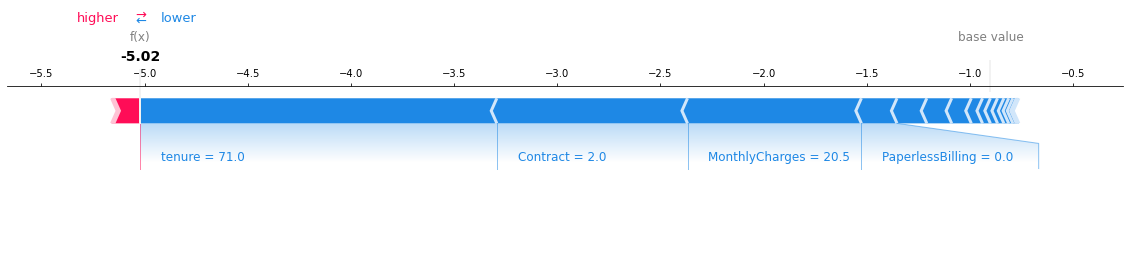

In [65]:
print(f'The model predict customer will: {("churn" if y_test.iloc[np.argmin(y_prob)]==1 else "not churn")} from y_test')
plot_shap(np.argmin(y_prob))

In [66]:
x_test_shap.iloc[np.argmin(y_prob)]

gender                 0.00
SeniorCitizen          0.00
Partner                1.00
Dependents             1.00
tenure                71.00
PhoneService           1.00
MultipleLines          0.00
InternetService        2.00
OnlineSecurity         1.00
OnlineBackup           1.00
DeviceProtection       1.00
TechSupport            1.00
StreamingTV            1.00
StreamingMovies        1.00
Contract               2.00
PaperlessBilling       0.00
PaymentMethod          0.00
MonthlyCharges        20.50
TotalCharges        1500.95
Name: 1945, dtype: float64

The observation in which our model predict the candidate that has the lowest probability to look for a job change on x_test, has `tenure = 71`,`contract  = two years`,  `Monthly Charges = 20.5`, `Paperless Billing = No`.

## Example Application

In [67]:
df_app = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_test = df_app.iloc[x_test.index][['customerID']]
df_test['y_pred'] = y_pred
df_test['y_test'] = y_test
df_test = df_test.set_index('customerID')
df_test[df_test['y_test']==1]

,y_pred,y_test
customerID,,
8128-YVJRG,1,1
5835-BEQEU,1,1
0623-IIHUG,1,1
0617-AQNWT,0,1
5980-NOPLP,1,1
...,...,...
5419-JPRRN,1,1
4745-LSPLO,0,1
8433-WXGNA,1,1


In [68]:
df_test[df_test['y_pred']==1]

,y_pred,y_test
customerID,,
8128-YVJRG,1,1
4445-ZJNMU,1,0
5835-BEQEU,1,1
0623-IIHUG,1,1
4226-KKDON,1,0
...,...,...
4176-FXYBO,1,0
6946-LMSQS,1,1
8903-XEBGX,1,0


In [69]:
df_test[(df_test['y_pred']==1)&(df_test['y_test']==1)]

,y_pred,y_test
customerID,,
8128-YVJRG,1,1
5835-BEQEU,1,1
0623-IIHUG,1,1
5980-NOPLP,1,1
4988-IQIGL,1,1
...,...,...
9940-RHLFB,1,1
5419-JPRRN,1,1
8433-WXGNA,1,1


In [70]:
df_test[(df_test['y_pred']==0)&(df_test['y_test']==1)]

,y_pred,y_test
customerID,,
0617-AQNWT,0,1
2634-HCZGT,0,1
5876-HZVZM,0,1
4760-XOHVN,0,1
2225-ZRGSG,0,1
...,...,...
1041-RXHRA,0,1
9412-ARGBX,0,1
6481-OGDOO,0,1


In [71]:
df_test["y_test"].count()

1407

# Conclusion

## Summary Model

In [74]:
pd.DataFrame({'Model':["KNN","Decision Tree","Logistic Regresion","Random Forest","XGB","Catboost","Logistic Regression with Feature Selection","Logistic Regression with Nearmiss","Logistic Regression with SMOTE","Logistic Regression with Class Weight","Logistic Regression with Class Weight and After Tuning"],
             'F2 score Train':[mean[0],mean[1],mean[2],mean[3],mean[4],mean[5]," ",mean_imb[0],mean_imb[1],mean_imb[2]," "],
              'F2 score Test':[f2_score[0],f2_score[1],f2_score[2],f2_score[3],f2_score[4],f2_score[5],f2_score_sel,f2_score_imb[0],f2_score_imb[1],f2_score_imb[2],f2_tun],
             }).set_index('Model')

,F2 score Train,F2 score Test
Model,,
KNN,0.532619,0.523319
Decision Tree,0.421327,0.414219
Logistic Regresion,0.558147,0.582040
Random Forest,0.50775,0.500562
XGB,0.53574,0.530556
Catboost,0.546704,0.514997
Logistic Regression with Feature Selection,,0.529543
Logistic Regression with Nearmiss,0.658361,0.667634
Logistic Regression with SMOTE,0.712821,0.728155


In [73]:
print("Classification Report Final Model \n",cr_imb[2])

Classification Report Final Model 
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      1033
           1       0.53      0.80      0.64       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.73      1407
weighted avg       0.81      0.75      0.77      1407



<p style='text-align: justify;'> Dataset contains information about customer who churn or not churn.
We tried 5 models and got the result with high marks (strong learner) which are Catboost, Xgboost, Random forest, KNN, and Logistic regression. This dataset more suitable with Logistic Regression model and give best performance than the others.
    
<p style='text-align: justify;'> This dataset have imbalance target data with the number of label 0 is 3 times more than label 1. To handle it, we compared 3 methods, which are Nearmiss (Undersampling),SMOTE (Oversampling) and, balanced class weight. The result is SMOTE have best performance, but not stable, so we used Class weight.
    
<p style='text-align: justify;'> To optimize the model, we did hyperparameter tunning using grid search and found model before tuning gave better performance. To make our model is explainable and interpretable, we used SHAP method. With SHAP, we can answer the business problem to help Company reach their goals as mentioned in the problem statement. </p>

Factor that make customer will churn or not, are :

1. Payment and duration of Subscribe have the most impact to customer churn or not
    * Tenure: Short period of tenure increase probability the customer to churn.
    * Contract: Short period of subscribe increase probability the customer to churn.
    * Monthly Charges: High montlhy charges increase probability the customer to churn.
    * Total Charges : High total charges increase probability the customer to churn.
    * Payment method : Customer with automatic payment have less probability to churn.

2. Product & Services also give impact to customer churn or not
    * Online Security, Backup, Device Protection, Multiple lines and Phone Service : Customer who not use that product have more probability to churn.
    * Tech Support : Customer who not use tech support have more probability to churn.
    * Internet Service : Customer who not use Internet service have more probability to churn.
    * Streaming Movies and TV : Customer who use streaming Movies or TV have more probability to churn.

3. Personal information can help us to determine customer who will churn or not
    * Dependent: Customer who have dependent have less probability to churn.
    * Senior citizen : Senior citizen have more probability to churn.
    * Partner & Gender : Partner and Gender have less impact to make customer churn.

## Business Insight

Churn has big impact for the company's profit. Based on analytics one customer spent cost 74.44 dollar with average tenure 32 month. Form this database, this company have 1869 customers was churned and company will loss 139,131.00 dollar per month and with average tenure company will loss 4,452,192 dollar. This model has performance 73%, its mean our model can predict (other factors are ignored) 1308 customers from 1869 customer which churn, and if our action is suitable, we can prevent 97367.52 dollar per month and with average tenure we will prevent company loss 3115760.64 dollar

The most impactfull feature based on our model, short period subscribe and high charges make customer will churn. Based on that analysis, company can offer discount to customer who will churn and give discount or free access for one month to upgrade their contract become one year contract or more. Beside that with our model we analyse senior citizen with no dependent will churn, so conmpany can adjust the package for senior citizen

## Recommendation

1. Make a bundle for all product with interesting cost.
2. Company can give discount for customer who predict will churn.
3. Company can give special offer to customer with shord period contract to prevent customer churn.
4. Company can reduce the price or increase the service of product (online security, tech support, and online back up).
5. For payment, Company should give more explaination about improvement of payment for customer because customer more like old method than the new one.
6. If company offer product to Senior Citizen, it can be their dependent that use the product and the Senior Citizen just pay or register only.
7. Give special treatment for new customers.